## Regression Task

In this part of the project, we aim to predict Olympic performance at the country level by modeling medal counts based on aggregated athlete characteristics:

* Number of athletes each country sends per Olympic year
* Average age of athletes representing each country per Olympic year
* Gender ratio (proportion of male and female athletes)
* Average height and weight of athletes per country-year

The purpose of this regression is to:

* Understand how demographic and physical traits of athletes relate to national performance
* Identify trends and key predictors of Olympic success at the country level
* Provide insights into the influence of athlete profiles on medal outcomes
* Support data-driven strategies for athlete development, talent scouting, and national sports planning

I initially attempted to predict individual athletes’ medal counts using features like age, height, weight and sex. However, this approach was ineffective, as majority of athletes won no medal, making the target variable highly imbalanced. As a result, the linear regression model performed poorly, with a very low R² score, highlighting a poor fit between the method and the data structure.

To overcome this, I shifted the focus to the country-year level and the question I want to answer now, with the regression model is:
**Can we predict how many medals a country will win in the Olympics based on its athletes’ age, gender,physical traits and the number of athletes country sends each year?**

Before building any models, I aggregate the data so that each row represents a country in a specific year, summarizing key traits such as average age, gender ratio,average height and weight of athletes and the number of athletes sent. Then I explore variable distributions and correlations using pairplots and distribution histograms, before proceeding to build regression models.

In [1]:
#let's get our preporcessed df from first notebook
import pandas as pd
df = pd.read_pickle("data/preprocessed_data.pkl") #use pickle to keep the data types 

# Group by region and year 
grouped = df.groupby(["region", "Year"]).agg(
    NumAthletes=("ID", "count"),                     
    AvgAge=("Age", "mean"),                          
    FemaleRatio=("Sex", lambda x: sum(x) / len(x)),  
    MedalCount=("Medal", lambda x: (x > 0).sum()),   
    AvgHeight=("Height", "mean"),
    AvgWeight=("Weight", "mean") 
).reset_index()

Lets see the first few rows to verify the grouped data looks correct.

In [2]:
print(grouped.head(15))

         region  Year  NumAthletes     AvgAge  FemaleRatio  MedalCount  \
0   Afghanistan  1936           16  24.347486     0.000000           0   
1   Afghanistan  1948           25  25.559783     0.000000           0   
2   Afghanistan  1956           12  25.559783     0.000000           0   
3   Afghanistan  1960           16  23.312500     0.000000           0   
4   Afghanistan  1964            8  22.444973     0.000000           0   
5   Afghanistan  1968            5  23.200000     0.000000           0   
6   Afghanistan  1972            8  27.279891     0.000000           0   
7   Afghanistan  1980           11  23.636364     0.000000           0   
8   Afghanistan  1988            5  25.559783     0.000000           0   
9   Afghanistan  1996            2  23.500000     0.000000           0   
10  Afghanistan  2004            5  18.600000     0.400000           0   
11  Afghanistan  2008            4  22.500000     0.250000           1   
12  Afghanistan  2012            6  24

### Correlation Matrix
To see all relationships upfront, I use a correlation matrix to identify which variables may explain medal outcomes and which add little or no value. These are useful insights for building the regression model later.

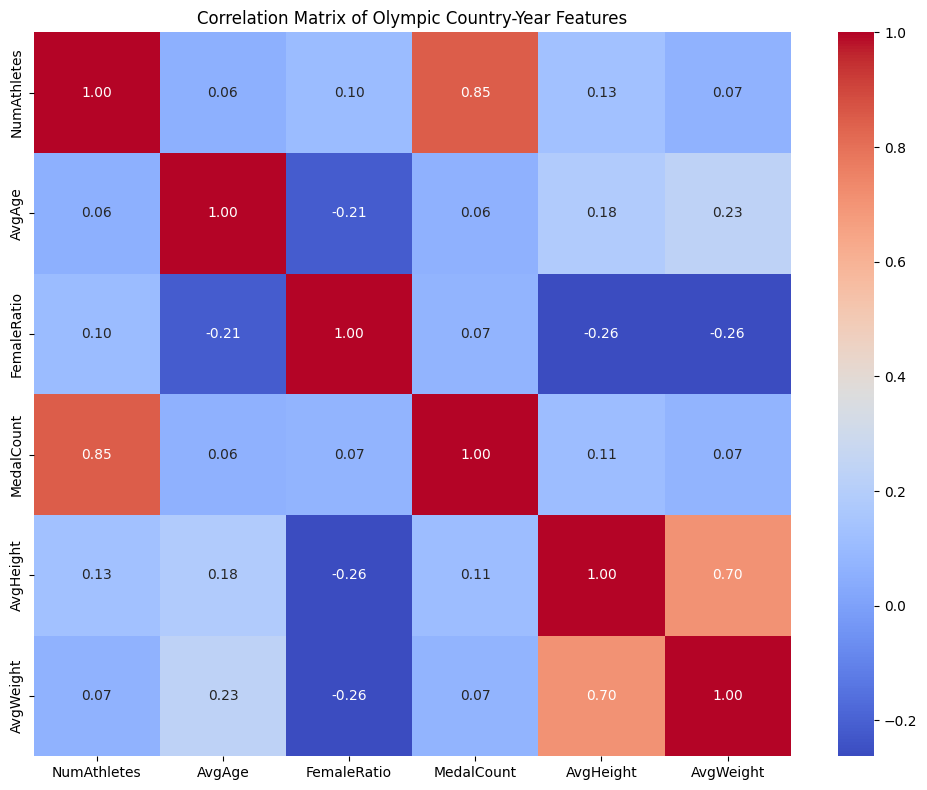

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = ["NumAthletes", "AvgAge", "FemaleRatio", "MedalCount", "AvgHeight", "AvgWeight"]
correlation_matrix = grouped[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Olympic Country-Year Features")
plt.tight_layout()
plt.show()

### Correlation Matrix Insights
As can be seen in the correlation matrix, the MedalCount is most strongly correlated with NumAthletes (0.85), which suggests that the more athletes a country sends, the more medals the country tends to win. This is not surprising, as more athletes means more chances to win.
Furthermore, the AvgAge (0.06), AvgHeight (0.11), and AvgWeight (0.07) don’t show a strong linear relationship with medal count.
Lastly, a FemaleRatio also has a small positive correlation with MedalCount (0.07).

### Pairplot Analysis
By using pairplots, I want to further explore possible relationships among the variables.

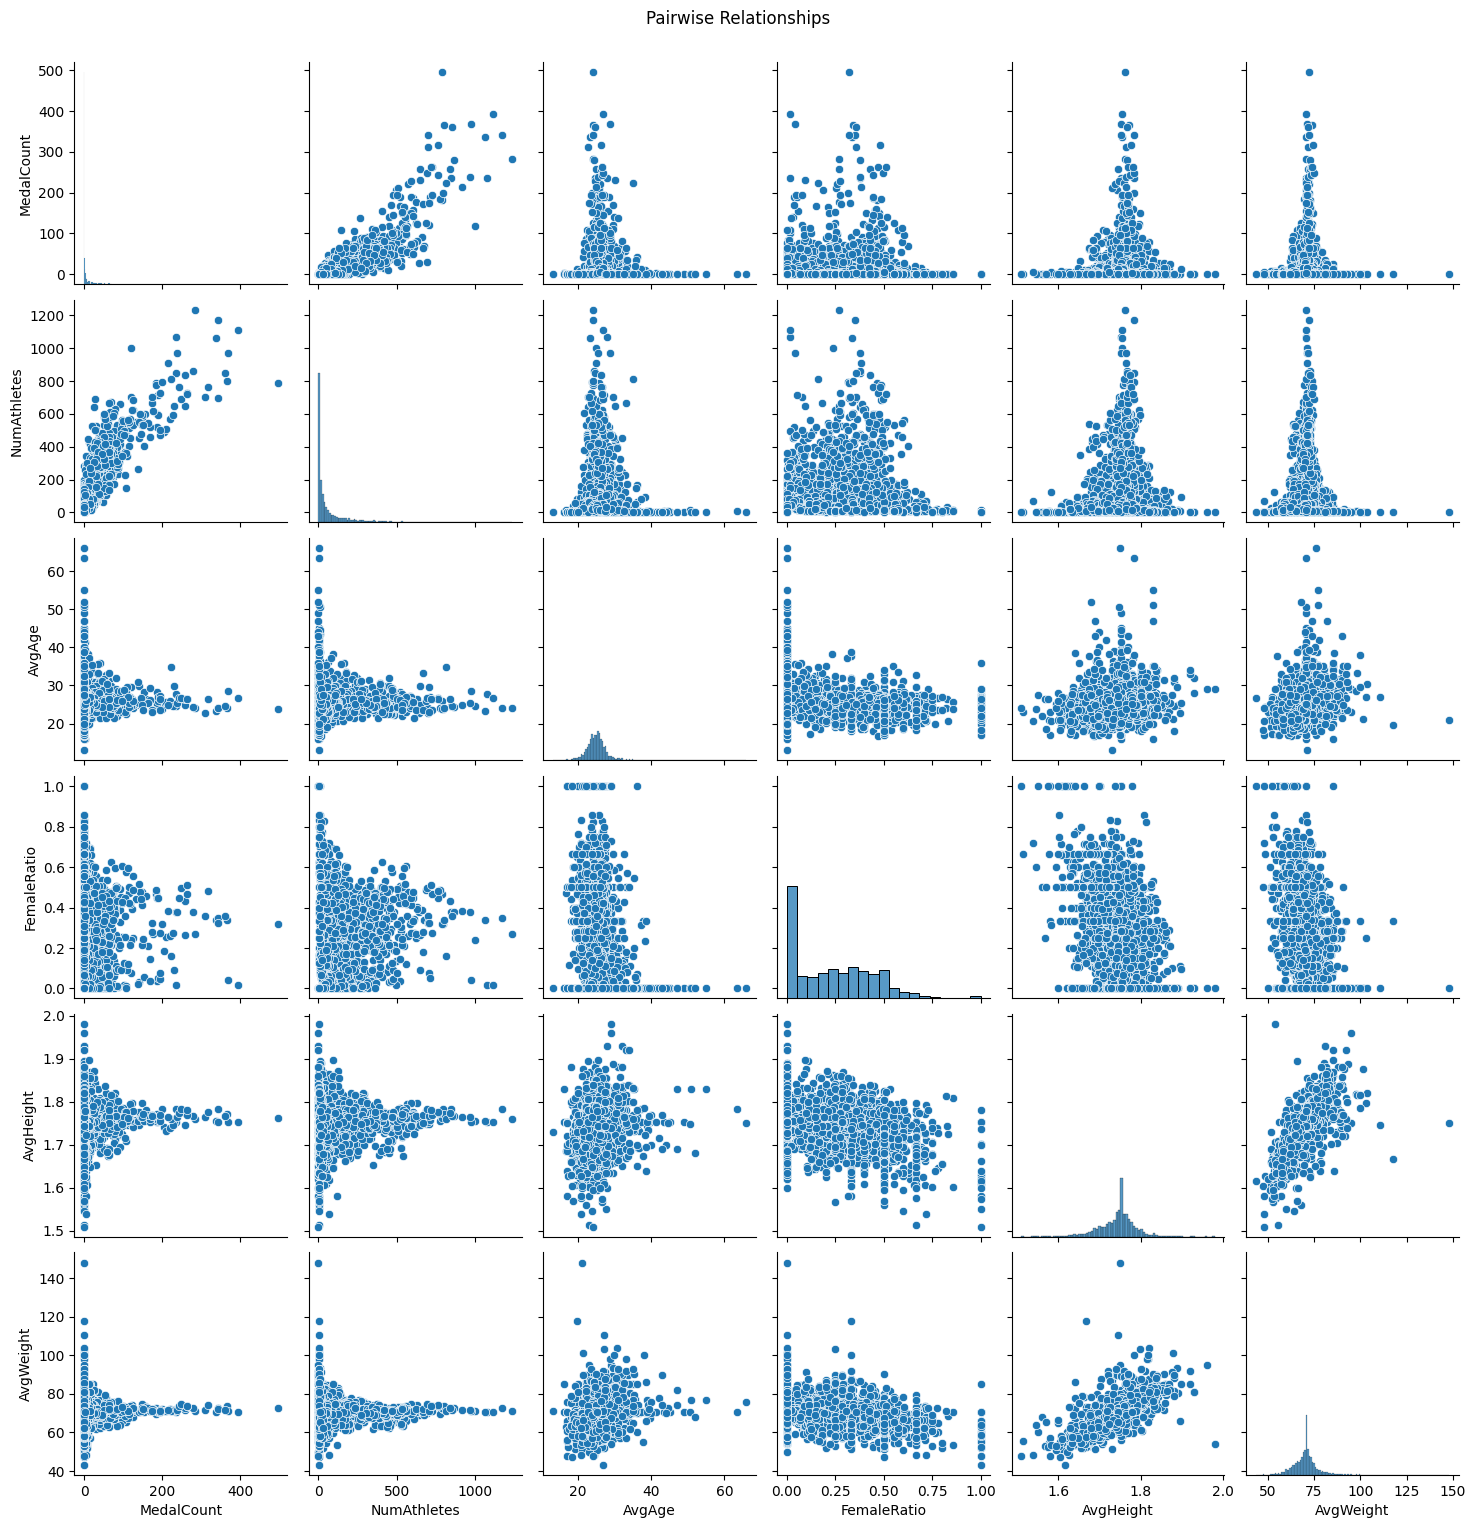

In [4]:
sns.pairplot(grouped[["MedalCount", "NumAthletes", "AvgAge", "FemaleRatio", "AvgHeight", "AvgWeight"]])
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()

### Pairplot Insights
The pairplot reveals a few relationships. Most notably, the number of athletes a country sends is strongly correlated with its medal count, suggesting a scale advantage. Additionally, average height and average weight show a linear relationship, which aligns with expectations as taller people tend to be heavier. 

### Distributions of Average Age, Height, and Weight Across Countries and Years
The histograms below show how **AvgAge**, **AvgHeight**, and **AvgWeight** are distributed across country-year combinations. This helps in better understanding whether these variables have enough variation, whether they follow a normal or skewed distribution, and whether any unusual values or outliers are present.

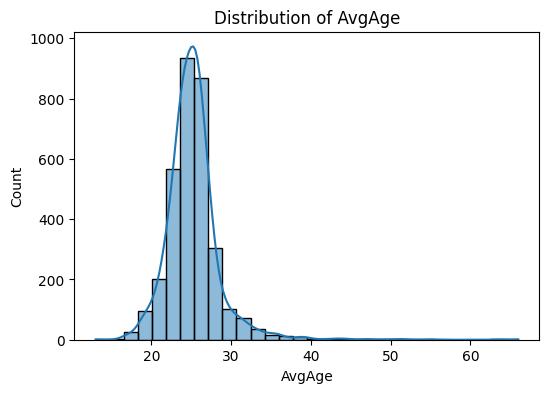

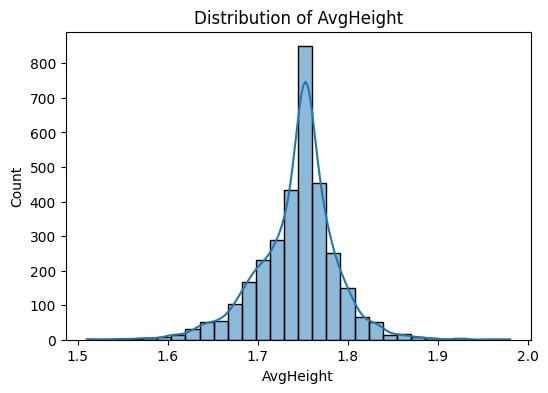

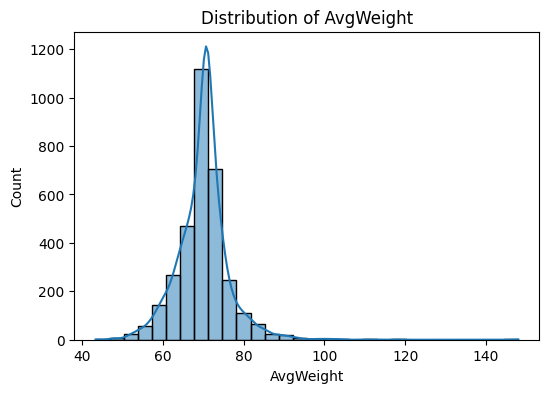

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

columns = ['AvgAge', 'AvgHeight', 'AvgWeight']

for col in columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=grouped, x=col, kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

### Distributions Insights
The distribution of **AvgAge** and **AvgWeight** is right-skewed, with most country-year values falling between 22–28 years and 60–80 kg, respectively. In contrast, **AvgHeight** shows a fairly symmetric, bell-shaped distribution centered around 1.75 meters.

## Linear Regression Model in sklearn

To build the first model, I used linear regression due to its simplicity and interpretability. I selected **NumAthletes**, **AvgAge**,**FemaleRatio**, **AvgWeight** and **AvgHeight** as explanatory variables because they represent team size, the general age level, the overall physique and body composition, and gender balance of athletes. NumAthletes had the strongest relationship with medal count, while the other variables might still help to improve the predictions.

In [6]:
from sklearn.model_selection import train_test_split

 
olympic_reg_data = grouped.loc[:, ["NumAthletes", "AvgAge", "FemaleRatio", "AvgHeight", "AvgWeight", "MedalCount"]]
olympic_reg_data.dropna(inplace=True) #this is just optional in case there are any NaNs but they were deatth with already

#features and target variable
olympic_reg_data = grouped.loc[:, ["NumAthletes", "AvgAge", "FemaleRatio", "AvgHeight", "AvgWeight", "MedalCount"]]

training, test = train_test_split(olympic_reg_data, test_size=0.2, random_state=22)

X_train = training.loc[:, training.columns != "MedalCount"]
y_train = training[["MedalCount"]].values.ravel()

X_test = test.loc[:, test.columns != "MedalCount"]
y_test = test[["MedalCount"]].values.ravel()

In [7]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression().fit(X_train, y_train)

linear_reg_pred_train = linear_reg.predict(X_train) #training data
linear_reg_pred = linear_reg.predict(X_test) #test data

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

print("Training Set Evaluation:")
print("MSE:", mean_squared_error(y_train, linear_reg_pred_train))
print("RMSE:", np.sqrt(mean_squared_error(y_train, linear_reg_pred_train)))
print("MAE:", mean_absolute_error(y_train, linear_reg_pred_train))
print("R²:", r2_score(y_train, linear_reg_pred_train))

print("\nTest Set Evaluation:")
print("MSE:", mean_squared_error(y_test, linear_reg_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, linear_reg_pred)))
print("MAE:", mean_absolute_error(y_test, linear_reg_pred))
print("R²:", r2_score(y_test, linear_reg_pred))

Training Set Evaluation:
MSE: 363.6337917271369
RMSE: 19.069184348763763
MAE: 9.274328534939102
R²: 0.7227257663415566

Test Set Evaluation:
MSE: 295.9311554650173
RMSE: 17.202649664078418
MAE: 9.14321263426447
R²: 0.714353534767325


### Evaluation Performance of Linear Regression (sklearn)

The linear regression model performs well, with an R² of 0.721 on training set and 0.717 on test set, meaning it explains about 72% of the variance in medal counts. The average prediction error is around 9 medals, which is reasonable given the range of values. As expected, the model performs slightly better on the training data, but its strong performance on the test set suggests it generalizes well and is not overfitting. Since the test data represent unseen observations, this provides a realistic estimate of how the model would perform in practice.

## Linear Regression Model in statsmodels
I also ran the linear regression using statsmodels to examine p-values and confidence intervals, which provide deeper insight into the statistical significance and reliability of each predictor in the model.

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

training, test = train_test_split(grouped, test_size=0.2, random_state=22)

linear_reg = smf.ols(formula="MedalCount ~ NumAthletes + AvgAge + FemaleRatio + AvgHeight + AvgWeight", data=training)
linear_reg_fit = linear_reg.fit()
print(linear_reg_fit.summary())

                            OLS Regression Results                            
Dep. Variable:             MedalCount   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     1357.
Date:                Mon, 30 Jun 2025   Prob (F-statistic):               0.00
Time:                        17:43:01   Log-Likelihood:                -11398.
No. Observations:                2610   AIC:                         2.281e+04
Df Residuals:                    2604   BIC:                         2.284e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.4803     17.814      0.364      

### Evaluation Performance of Linear Regression (statsmodels)
The linear regression model explains 72.1% of the variance in medal counts, indicating a strong overall fit. By looking at the p-values, we see that NumAthletes is the only statistically significant predictor (p < 0.001), suggesting that larger olympic team sizes are strongly associated with more medals. In contrast, AvgAge, FemaleRatio, AvgHeight and AvgWeight have higher p-values, above 0.05, meaning there’s no significant evidence that they impact medal counts. The confidence intervals show that the number of athletes is a statistically significant predictor of medal count, with a tight interval (0.210, 0.221), indicating a consistent positive impact. In contrast, the intervals for average age, female ratio, avergae heigth and weight  all include zero, suggesting their effects are statistically uncertain in this model. Overall, the model performs well, but most of its predictive power comes from the number of athletes a country sends.

### K-Nearest Neighbor Model
I’ll run the kNN model with k = 2 and k = 15 to compare how the number of neighbors affects prediction performance.

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

#k = 2
knn_2 = KNeighborsRegressor(n_neighbors=2)
knn_2_reg = knn_2.fit(X_train, y_train)

knn_2_pred_train = knn_2_reg.predict(X_train)
knn_2_pred_test = knn_2_reg.predict(X_test)

print("\nkNN (k=2) - Training Set:")
print("MSE:", mean_squared_error(y_train, knn_2_pred_train))
print("R²:", r2_score(y_train, knn_2_pred_train))

print("\nkNN (k=2) - Test Set:")
print("MSE:", mean_squared_error(y_test, knn_2_pred_test))
print("R²:", r2_score(y_test, knn_2_pred_test))


kNN (k=2) - Training Set:
MSE: 144.6250957854406
R²: 0.8897219853764916

kNN (k=2) - Test Set:
MSE: 326.4973200612557
R²: 0.6848496562084223


In [11]:
#k = 15
knn_15 = KNeighborsRegressor(n_neighbors=15)
knn_15_reg = knn_15.fit(X_train, y_train)

knn_15_pred_train = knn_15_reg.predict(X_train)
knn_15_pred_test = knn_15_reg.predict(X_test)

print("kNN (k=15) - Training Set:")
print("MSE: ", mean_squared_error(y_train, knn_15_pred_train))
print("R²: ", r2_score(y_train, knn_15_pred_train))

print("\nkNN (k=15) - Test Set:")
print("MSE: ", mean_squared_error(y_test, knn_15_pred_test))
print("R²: ", r2_score(y_test, knn_15_pred_test))

kNN (k=15) - Training Set:
MSE:  229.56349255002127
R²:  0.8249556479048953

kNN (k=15) - Test Set:
MSE:  269.59867279224096
R²:  0.7397708673373267


### Evaluation Performance of K-Nearest Neighbor Model
I tried running two kNN models with k = 2 and k = 15. With k = 2, the model achieved a very high R² of 0.89 on the training set, but the performance dropped to 0.71 on the test set, suggesting overfitting. In contrast, the k = 15 model had a slightly lower R² of 0.83 on the training set but a higher R² of 0.77 on the test set. This smaller gap between training and test results indicates better generalization. Additionally, the k = 15 model had a lower test set MSE (238 vs. 306), making it more reliable choice. Therefore, I select k = 15 for its stronger and more stable performance on unseen data.

### LASSO Model 
Lastly, I used Lasso regression because it helps prevent overfitting and automatically reduces the impact of less relevant variables. Since not all features like average age, gender ratio, average height or weight may significantly influence medal counts, Lasso can shrink their coefficients to zero, resulting in a simpler and more focused model.

In [12]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso().fit(X_train, y_train)

lasso_reg_pred_train = lasso_reg.predict(X_train) #training data
lasso_reg_pred = lasso_reg.predict(X_test) #test data

mse_train_lasso = mean_squared_error(y_train, lasso_reg_pred_train)
r2_train_lasso = r2_score(y_train, lasso_reg_pred_train)
mse_test_lasso = mean_squared_error(y_test, lasso_reg_pred)
r2_test_lasso = r2_score(y_test, lasso_reg_pred)

print("LASSO Mean Squared Error on the training set: ", mse_train_lasso)
print("LASSO R² Score on the training set: ", r2_train_lasso)
print("LASSO Mean Squared Error on the test set: ", mse_test_lasso)
print("LASSO R² Score on the test set: ", r2_test_lasso)

LASSO Mean Squared Error on the training set:  364.0453397086454
LASSO R² Score on the training set:  0.7224119570812992
LASSO Mean Squared Error on the test set:  296.68553104247405
LASSO R² Score on the test set:  0.7136253765008533


### Evaluation Performance of LASSO Model 
The Lasso regression model performed similarly to standard linear regression, with an R² of 0.721 on the training set and 0.716 on the test set. This suggests the model explains about 72% of the variance in medal counts. The slight drop in performance on the test set is minimal, indicating good generalization. However, Lasso did not significantly outperform linear regression, likely because most features already contributed meaningfully to the prediction.

## Comparison of Regression Models
Linear Regression (OLS) provides a solid predictive performance and offers clear interpretability through coefficients, p-values, and confidence intervals. It allows for understanding the relationships between athlete traits and medal counts.

LASSO Regression is useful when working with many predictors, particularly if some are noisy, irrelevant, or redundant. It helps by shrinking less important coefficients and potentially improving model simplicity and generalization. However, in this case, with a small set of meaningful variables, LASSO produced results almost identical to standard linear regression and did not offer additional benefits in terms of performance or feature selection.

kNN Regression showed the highest predictive performance on the test set (0.77). However, since it doesn't show how each feature affects the result, it's less useful for understanding or explaining relationships in the data.

Based on the analysis, I recommend choosing Linear Regression (OLS) as the final model. Among all tested models, Linear Regression offered the best balance between predictive accuracy and interpretability, making it the most suitable choice for both analytical and strategic purposes, which was the goal of this project. 

It demonstrated:

* Solid performance with an R² of 0.721 on the training set and 0.717 on the test set, explaining approximately 72% of the variance in medal counts
* An average prediction error (MAE) of around 9 medals, which is reasonable given the wide range of medal totals
* Full interpretability, with statistically significant predictors (NumAthletes, p < 0.001) and narrow confidence intervals (0.210 to 0.221 for the effect of team size)

## Conclusion
Even though Linear Regression was identified as the most suitable model, its predictive performance was far from perfect. While it explained about 72% of the variance in medal counts, the results showed that only the number of athletes a country sends was a statistically significant predictor. Other variables, such as average age, gender ratio, height, and weight did not show significant effects in the model.

It's important to acknowledge that predicting the likelihood of winning Olympic medal is very complex if not impossible. Athletic performance is influenced by many hard-to-measure factors such as coaching quality, team dynamics, mental preparedness, national investment in sports, and even luck, none of which are fully captured in the available data.

This project demonstrates that aggregated athlete characteristics can provide some explanatory power, but much of what drives Olympic outcomes remains outside the scope of quantitative models.